# 🧪 The Great Divide: A/B Testing and Hypothesis Testing

In this notebook, we'll be going over a comprehensive review of **A/B Testing** and the different types of statistical tests used in A/B testing. This may require you to have some prerequisite knowledge on inferential statistics. Fortunately, as a former statistics TA, I wrote an entire series on an introduction to inferential statistics on my blog. Check it out at [benchenblog.com](http://benchenblog.com) if you're interested. Anyways, let's begin shall we!

# Modules/Packages

There's not a whole lot of modules that we'll be using in this notebook, since most statistical tests are packaged in either `scipy` or `statsmodel`. Other than the two, we'll just import the usual ones like `numpy`, `numpy` and `matplotlib`. Personally, I prefer to use `seaborn` for data visualization, so let's import it as well.

In [1]:
#import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest

# Dataset

In this notebook, we'll be dealing with a rather simple dataset from the mobile game *Cookie Cats*. It only contains five variables in total, so let's take a look at them one by one. 

* `userid` - the `userid` is just the user id. Each unique id represents a unique player. Nothing special here.
* `version` - `version` takes on two values: `gate_30` and `gate40`. When users are playing this game, they encounter gates that force them to wait a while before they can progress. `gate_30` and `gate_40` just means that the gate is placed at level 30 and level 40, respectively. `version` is also our group of interest. We want to perform A/B testing to determine whether placing the gate at these two different levels would impact player retention and game rounds.
* `sum_gamerounds` - the number of game rounds played by the user in the first week of installation
* `retention_1` (bool) - whether the user came back to play the game 1 day after installation
* `retention_7` (bool) - whether the user came back to play the game 7 days after installation

In [2]:
#read data
data = pd.read_csv("../data/cookie_cats.csv")
data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


We also have quite a lot of samples in our dataset. In total, we have 90189 samples, which should be more than enough for us to perform our A/B testing.

In [3]:
data.shape

(90189, 5)

# Exploratory Data Analysis (EDA)

Okay, now let's take a deeper dive into our dataset by constructing some data visualizations. We'll start with the distribution for `version`, our group of interest.

## version

<Axes: xlabel='version', ylabel='count'>

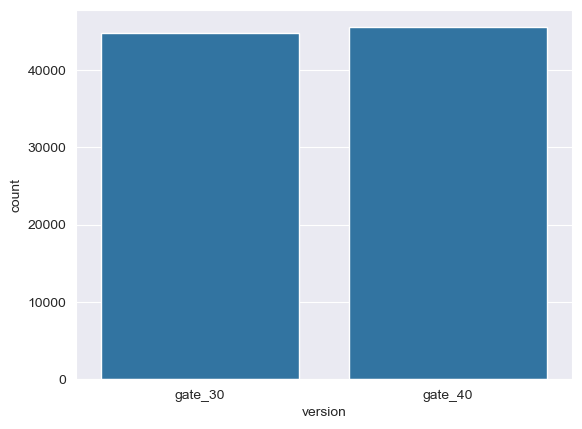

In [4]:
#plot count plot
sns.countplot(data=data, x="version")

We can see that the counts for the values are roughly the same, both having more than 40,000 counts. The counts of `gate_40` does slightly exceed that of `gate_30`. Next, let's try to visualize `sum_gamerounds`. Since this varaible is numerical, we'll plot it using a histogram.

## sum_gamerounds

<Axes: xlabel='sum_gamerounds', ylabel='Count'>

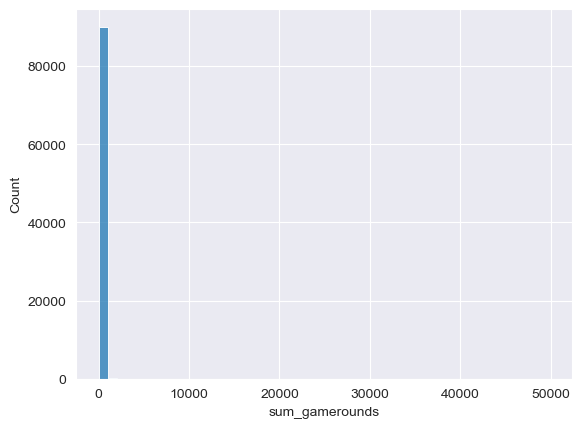

In [5]:
#plot histogram
sns.histplot(data=data, x="sum_gamerounds", bins=50)

Woah! What happened here? Although it seems like there are no values to the right of the histogram, there actually are. It's just that the count is way too small compared to the first bin, where most value lies. Let's check the boxplot instead.

<Axes: xlabel='sum_gamerounds'>

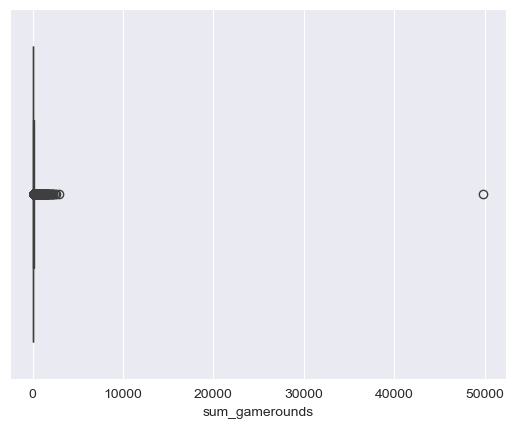

In [6]:
#plot boxplot
sns.boxplot(data=data, x="sum_gamerounds")

Ah, now we can see the problem. Apparently, there is one extreme outlier that played nearly 50,000 rounds of game within 1 week of installation. That's insane! This person must really love this game! If not, it's probably due to a bug or data error. For the sake of our test, we'll have to remove this abnormal sample. Next, let's take a look at `retention_1`. 

## retention_1

<Axes: xlabel='retention_1', ylabel='count'>

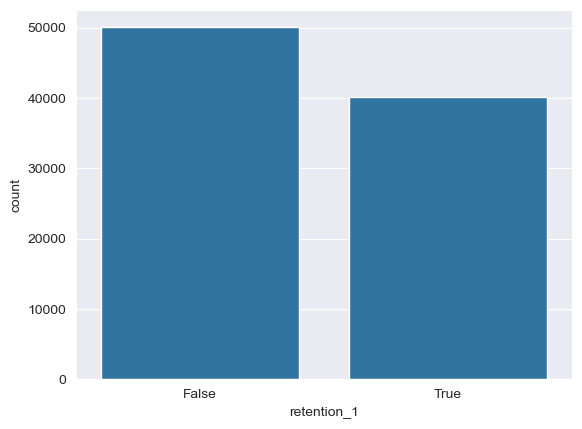

In [7]:
#plot countplot
sns.countplot(data=data, x="retention_1")

We can see that there are more `False` values than `True`. This means that most people (more than 50%) never played the game again after 1 day of installation. Perhaps, this is something that the developers can think about if they want to retain more loyal players.

## retention_7

<Axes: xlabel='retention_7', ylabel='count'>

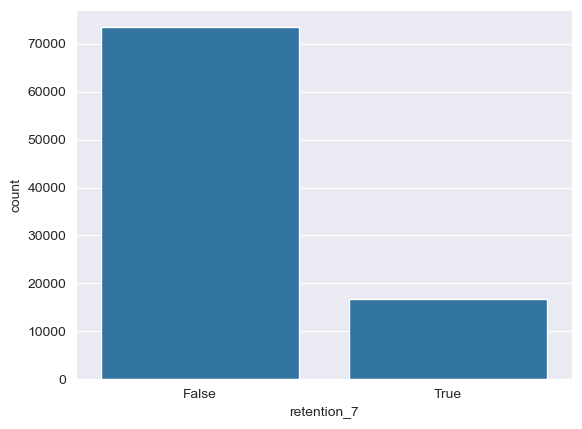

In [8]:
#plot countplot
sns.countplot(data=data, x="retention_7")

As expected, the number of players that continued to play this game after 1 week of installation drops even lower. At the end of the day, this game is likely designed for some immediate satisfaction, and not for long-term dedication like many role-playing games are designed to do.

## Remove Outlier

Okay, now as mentioned before, let's remove that one single outlier.

In [9]:
#remove outlier
data = data.drop(data[data.sum_gamerounds > 40000].index)

# Bivariate EDA

Now that we have removed that outlier, let's visualize our data again. This time, we'll be looking at how the three variables `sum_gamerounds`, `retention_1` and `retention_7` distribute among the two `version` groups.

## sum_gamerounds
With that extreme outlier out of the way, we finally get to see how `sum_gamerounds` is distributed. The distribution of `sum_gamerounds` seems to be roughly the same for the two versions. Both seem to have a right-skewed distribution. Given this simple visualization, we can already have an initial guess that the different versions (`gate_30` and `gate_40`) will not have a huge impact on the values of `sum_gamerounds`. Of course, this is only just an initial guess. We'll need to perform statistical tests to back up any claim.

<Axes: xlabel='sum_gamerounds', ylabel='version'>

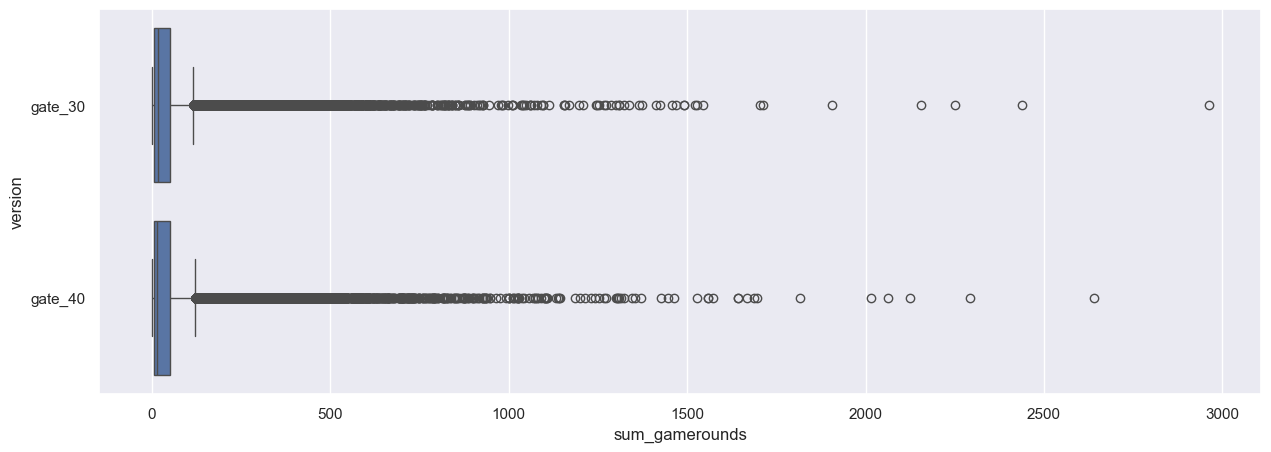

In [10]:
#set figure size
sns.set(rc={'figure.figsize':(15, 5)})
#plot boxplot
sns.boxplot(data=data, x="sum_gamerounds", y="version")

The boxplots above may still be unclear due to their skewness. So let's take a look at their specific statistics to see if we can extract some more insights.

In [11]:
#obtain descriptive statistics for sum_gamerounds
data.sum_gamerounds.describe()

count    90188.000000
mean        51.320253
std        102.682719
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max       2961.000000
Name: sum_gamerounds, dtype: float64

Let's also zoom into histogram for when `sum_gamerounds` (the x-axis) is less than 200. Setting the bins as the maximum value of `sum_gamerounds` allows us to easily identify that most players only once in the first week after installation. There was also a surprising amount of players who didn't play the game at all! Perhaps, developers of the game need to investigate into this issue. 

(0.0, 200.0)

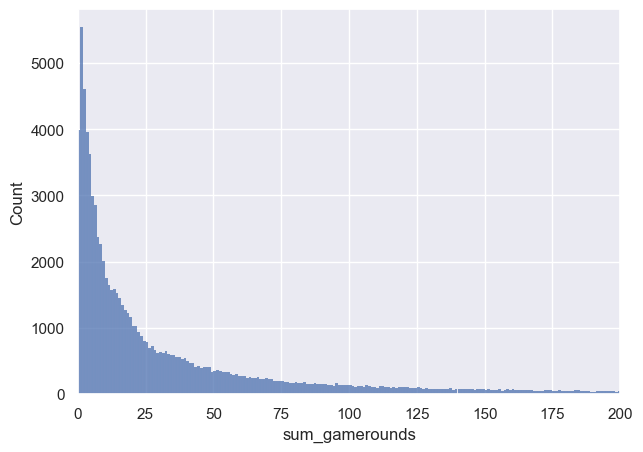

In [12]:
#set figure size
sns.set(rc={'figure.figsize':(7, 5)})
#plot histogram
sns.histplot(data["sum_gamerounds"], bins=2961)
#limit x-axis to range (0, 200)
plt.xlim(0, 200)

## retention_1

Our next variable in the line is `retention_1`. Since this variable is categorical variable, we can easily compare its distribution between the two version using a count plot.

<Axes: xlabel='retention_1', ylabel='count'>

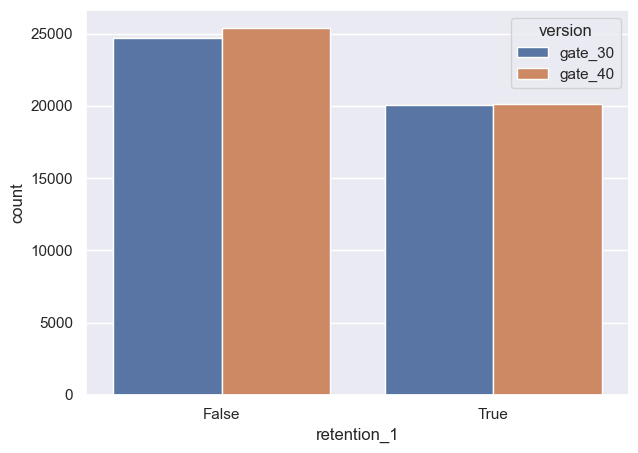

In [13]:
#plot count plot
sns.countplot(data=data, x="retention_1", hue="version")

Again, it appears that the proportion of those players who retained after one day of installation is approximately the same among the two versions. Remember that this dataset contains more samples for version `gate_40` and so if the two proprotions were equal, both orange bars should exceed the blue bars by a little bit. We'll also have to perform a hypothesis testing to validate this hypothesis.

## retention_7

What was mentioned about `retention_1` would also apply to `retention_7`. Let's see if we can identify any differences here.

<Axes: xlabel='retention_7', ylabel='count'>

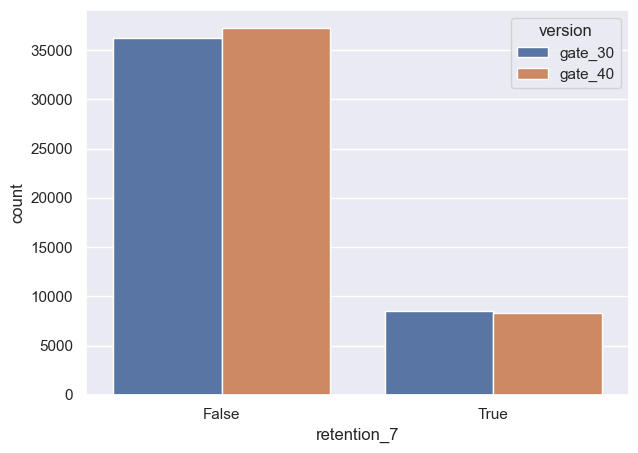

In [14]:
#plot count plot
sns.countplot(data=data, x="retention_7", hue="version")

Do you see the difference between the count plot of `retention_1` and `retention_7`? In the count plot of `retention_7`, the orange count bar (`gate_40`) is higher than the blue count bar (`gate_30`) for `False` values, but less for `True` values. This is interesting because we just said that, if the two proportion of retention is the same, then both orange bars should be slightly higher than that of the blue bars. We might be able to identify a difference here. Of course, we can only conclude after we perform the hypothesis test.

# Hypothesis Testing

Okay, now that we have a pretty good general idea of our data, we can finally perform our A/B testing! But this is actually the trickiest part. There are many different options of statistical tests out there for you to choose. Which one should we use? Let's not jump too far ahead yet. We'll first seperate our data into the control and treatment group so it can be fed into our tests. 

In [15]:
#seperate control and treatment group
control = data[data["version"]=="gate_30"]
treatment = data[data["version"]=="gate_40"]

## sum_gamerounds

The general rule of thumb for determining which statistical test to use depends on the variable type as well as the different assumptions required for different tests. We'll start with `sum_gamerounds`, a numerical variable.

In [16]:
#distributions for sum_gamerounds
gamerounds_control = control["sum_gamerounds"]
gamerounds_treatment = treatment["sum_gamerounds"]

### Two Sample t-test

We have two samples here, a control and a treatment. And if you recall from your statistics 101 classes, then you should know that we can perform a **two sample t-test** to test whether the unknown population means of two groups are equal or not. This is certainly an option, but we must also remember the conditions/assumptions required for the two sample t-test. 

* Data values must be independent
* Data in each group follow a normal distribution
* The variances for the two groups are equal

We know that the data values are independent because they were collected from different users, but are the two distributions normal? From our previous visualization, we already have an idea that the distribution is likely skewed. To verify this, we have to perform other statistical tests to see if the distribution is normal or not. The same applies for assumption 3 (equal variances). We would also have to perform other statistical tests to conclude that they have equal variance. 

### Welch's t-test

In the case where the first two conditions are satisfied, but not the third (unequal variances), we may have to opt for a **Welch's t-test**. Some even argue that we should always perform the Welch's t-test over the two sample t-test, because it's very unlikely that the variance between two variances will ever be the same.


### Check for Normality

Anyways, let's check whether our second condition (normality) is fulfilled or not. Again, we are left with many different options to check for normality. Here, I'll introduce three of the most commonly used methods: **Shapiro-Wilk Test**, **Kolmogorov–Smirnov Test**, and the **Q-Q Plot**. Let's go over them one by one.



### Shapiro-Wilk Test

The implemetation of the **Shapiro-Wilk Test** is quite simple. We can directly import it from the `scipy.stats` package and we just feed the distribution into the function. The null hypothesis is that the data follows a normal distribution. Using a 0.05 level of significance, we can see that, for both the control and treatment distribution, we rejected our null hypothesis and concluded that they do not follow a normal distribution.

In [17]:
#compute test statistics and p-value for our two distributions to check for normality
control_shapiro_stat, control_shapiro_p = stats.shapiro(gamerounds_control)
treatment_shapiro_stat, treatment_shapiro_p = stats.shapiro(gamerounds_treatment)

#control group results
print("Shapiro-Wilk test statistic for control group: ", control_shapiro_stat)
print("P-value for control group: ", control_shapiro_p)
if control_shapiro_p > 0.05:
    print("There is not enough evidence to reject the null hypothesis (control group sample follows a normal distribution)")
else:
    print("There is enough evidence to reject the null hypothesis (control group sample does not follow a normal distribution) ")
    
#treatment group results
print("\nShapiro-Wilk test statistic for treatement group: ", treatment_shapiro_stat)
print("P-value for treatment group: ", treatment_shapiro_p)
if treatment_shapiro_p > 0.05:
    print("There is not enough evidence to reject the null hypothesis (treatment group sample follows a normal distribution)")
else:
    print("There is enough evidence to reject the null hypothesis (treatment sample does not follow a normal distribution) ")

Shapiro-Wilk test statistic for control group:  0.48864299058914185
P-value for control group:  0.0
There is enough evidence to reject the null hypothesis (control group sample does not follow a normal distribution) 

Shapiro-Wilk test statistic for treatement group:  0.4825664758682251
P-value for treatment group:  0.0
There is enough evidence to reject the null hypothesis (treatment sample does not follow a normal distribution) 


/Users/benchen/miniconda3/envs/cookie-cat/lib/python3.12/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


### Kolmogorov–Smirnov test

The exact same code can be applied to the **Kolmogorov–Smirnov Test**, except we change `stats.shapiro` to `stats.kstest`. The KS test also indicates that both distributions are not normal.

In [18]:
#compute test statistics and p-value for our two distributions to check for normality
control_kstest_stat, control_kstest_p = stats.kstest(gamerounds_control, "norm")
treatment_kstest_stat, treatment_kstest_p = stats.kstest(gamerounds_treatment, "norm")

#control group results
print("KS test statistic for control group: ", control_kstest_stat)
print("P-value for control group: ", control_kstest_p)
if control_kstest_p > 0.05:
    print("There is not enough evidence to reject the null hypothesis (control group sample follows a normal distribution)")
else:
    print("There is enough evidence to reject the null hypothesis (control group sample does not follow a normal distribution) ")

#treatment group results
print("\nKS test statistic for treatement group: ", treatment_kstest_stat)
print("P-value for treatment group: ", treatment_kstest_p)
if treatment_kstest_p > 0.05:
    print("There is not enough evidence to reject the null hypothesis (treatment group sample follows a normal distribution)")
else:
    print("There is enough evidence to reject the null hypothesis (treatment sample does not follow a normal distribution) ")

KS test statistic for control group:  0.8724153079945488
P-value for control group:  0.0
There is enough evidence to reject the null hypothesis (control group sample does not follow a normal distribution) 

KS test statistic for treatement group:  0.8707186187388001
P-value for treatment group:  0.0
There is enough evidence to reject the null hypothesis (treatment sample does not follow a normal distribution) 


### Q-Q Plot

Our last method, plotting the **Q-Q Plot**, serves only as a visual check for normality. In essence, if a distribution, a Q-Q plot should display a straight dotted line. However, we can see in the two Q-Q plots below, they are not straight at all. Instead, the upward curve resembles a right-skewed distribution, which matches with our initial data visualization.

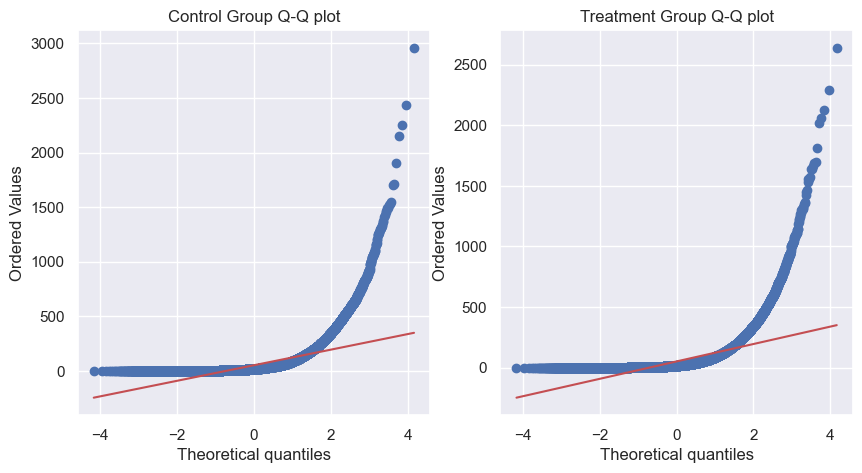

In [19]:
sns.set(rc={'figure.figsize':(10, 5)})
fig, ax = plt.subplots(1,2)

#Q-Q Plot
stats.probplot(gamerounds_control, plot=ax[0])
stats.probplot(gamerounds_treatment, plot=ax[1])
ax[0].set_title("Control Group Q-Q plot")
ax[1].set_title("Treatment Group Q-Q plot")
plt.show()

Okay, so all three tests say that the two distributions are not normal. What now? If the normality condition is not satisfied, what statistical test should we perform? We'd have to resort to non-parametric tests, where no assumption about the distribution is required. Here, we can use the **Mann-Whitney U Test** to compare two medians (not the mean), which would be a better measure of central tendency than the mean when distributions are skewed.

### Mann-Whitney U Test

The implementation of the **Mann-Whitney U Test** is also very simple in python. The null hypothesis for this test is that the two samples may come from the same distribution, which means that there should also be no significant difference in central tendency.

In [20]:
#perform the Mann-Whitney U test
mw_stat, mw_p = stats.mannwhitneyu(gamerounds_control, gamerounds_treatment)

#print the results
print('Mann-Whitney U statistic:', mw_stat)
print('P-value:', mw_p)

if mw_p > 0.05:
    print("There is not enough evidence to reject the null hypothesis (The two samples may come from the same distribution)")
else:
    print("There is enough evidence to reject the null hypothesis (The two samples may come from different distributions)")

Mann-Whitney U statistic: 1024285761.5
P-value: 0.05089155279145375
There is not enough evidence to reject the null hypothesis (The two samples may come from the same distribution)


As we can see from the result of the Mann-Whitney U Test, there is no significant evidence to reject the null hypothesis. We can thus conclude that the two samples may come from the same distribution and that the version type plays no role in affecting the values of sum_gamerounds. However, we must also acknowledge the fact that the p-value is 0.0508, just slightly above our level of significance of 0.05. This means that the result would be significant if we modified our level of significance to be just slightly higher.

## Retention 1

Okay, so that was the result for the variable `sum_gamerounds`. At a 0.05 level of significance, we concluded that there is no difference in the `sum_gamerounds` of `gate_30` and `gate_40`. Let' move on to our next variable, `retention_1`. Unlike `sum_gamerounds`, `retention_1` is a categorical variable (boolean datatype to be more specific). So instead of testing for mean or median, we would be testing the difference in proportion. There are generally two test options to test for proportion: **Two-sample Z Test for Proportions** and the **Chi-square Test of Independence**.

### Two-sample Z Test for Proportions

The rule of thumb in determining which test to perform is to look at the sample size. The **Two-sample Z Test for Proportions** assumes that the sample sizes are large enough for the normal approximation to the sampling distribution. In our dataset, we have plenty of samples, so there should be no problem in conducting this test. To conduct the **Two-sample Z Test for Proportions**, we have to take the values of the number of successes and the total number of observations, and feed it into the `proportions_ztest` function (from `statsmodel.stats.proportion`).

In [21]:
#number of True values for retention_1 in control and treatment group
retention_1_successes = np.array([sum(control["retention_1"]), sum(treatment["retention_1"])])
#total number of observations in control and treatment group
retention_1_nobs = np.array([len(control["retention_1"]), len(treatment["retention_1"])])  

retention_1_successes, retention_1_nobs

(array([20034, 20119]), array([44699, 45489]))

In [22]:
#perform two-sample Z test for proportions
retention_1_stat, retention_1_p = proportions_ztest(count=retention_1_successes, nobs=retention_1_nobs)

#print the results
print("retention_1 Z test statistics two sample proportions:", retention_1_stat)
print("retention_1 p-value:", retention_1_p)

if retention_1_p > 0.05:
    print("There is not enough evidence to reject the null hypothesis (The two proportions may be the same)")
else:
    print("There is enough evidence to reject the null hypothesis (The two proportions may be different)")

retention_1 Z test statistics two sample proportions: 1.787103509763628
retention_1 p-value: 0.0739207603418346
There is not enough evidence to reject the null hypothesis (The two proportions may be the same)


The test results indicate that at 0.05 level of signficance, we do not reject the null hypothesis and that there is no significant difference in the two proportions. This is also consistent with our initial guess during the data visualization stage. 

### Chi-square Test of Independence

The **Chi-square Test of Independence**, the other option, tests for independence between two categorical variables. This is a non-parametric test, which means it doesn't make any assumptions about the underlying distribution of the data. So in case where sample size is small, it may be more appropriate to use the chi-square test instead of the two-sample Z test for proportions. But do note that the chi-square test also has assumptions of its own. In particular: 

- Both variables are categorical
- Observations are independent
- Observations are mutually exclusive
- Expected values of cells should be greater than five

For those who are not familiar with the chi-square test, this may come across as confusing. But the idea behind chi-square test is actually really simple and I encourage you to read about it. There are plenty of resources online, so I won't go into the deep details behind it. For now, just know that all four of these assumptions are satisfied and that we can indeed perform this test. 

The implementation is simple. We construct the observed contingency table for our two variables and then feed it into the `chi2_contingency` function from `scipy.stats`. The function will return the test statistics, p-value, degree of freedom and the expected contingency table.

In [23]:
#construct observed contingency table
retention_1_observed = np.array([[sum(control["retention_1"]), len(control["retention_1"])-sum(control["retention_1"])],
                                 [sum(treatment["retention_1"]), len(treatment["retention_1"])-sum(treatment["retention_1"])]])

retention_1_observed

array([[20034, 24665],
       [20119, 25370]])

In [24]:
#return test statistics, p-value, df and expected contingency table
retention_1_chi2_stat, retention_1_chi2_p, retention_1_dof, retention_1_expected = stats.chi2_contingency(retention_1_observed)

#print the results
print("Chi-square test statistics for retention_1: ", retention_1_chi2_stat)
print("P-value for retention_1: ", retention_1_chi2_p)
print("Degree of freedom: ", retention_1_dof)
print(retention_1_expected)

if retention_1_chi2_p > 0.05:
    print("There is not enough evidence to reject the null hypothesis (The two proportions may be the same)")
else:
    print("There is enough evidence to reject the null hypothesis (The two proportions may be different)")

Chi-square test statistics for retention_1:  3.169835543170799
P-value for retention_1:  0.07500999897705672
Degree of freedom:  1
[[19900.64029583 24798.35970417]
 [20252.35970417 25236.64029583]]
There is not enough evidence to reject the null hypothesis (The two proportions may be the same)


The result of the chi-square test is consistent with the two-sample Z test for proportions. At a 0.05 level of significance, there is not enough evidence to reject the null hypothesis, so we can conclude that there are no relationship between `version` and `retention_1` (they are independent).

## Retention 7

Phew! Now we're finally down to our final variable, `retention_7`. This variable is essentially the same thing as `retention_1`. But remember that during the data visualization stage, we said that there could potentially be a significant difference in `retention_7` proportion between the two versions. Let's do the same two-sample Z test for proportions and chi-square test to check if our hypothesis is correct.

### Two-sample Z Test for Proportions

In [25]:
retention_7_successes = np.array([sum(control["retention_7"]), sum(treatment["retention_7"])])
retention_7_nobs = np.array([len(control["retention_7"]), len(treatment["retention_7"])])  

retention_7_successes, retention_7_nobs

(array([8501, 8279]), array([44699, 45489]))

In [26]:
retention_7_stat, retention_7_p = proportions_ztest(count=retention_7_successes, nobs=retention_7_nobs)

print("retention_7 Z test statistics two sample proportions:", retention_7_stat)
print("retention_7 p-value:", retention_7_p)

if retention_7_p > 0.05:
    print("There is not enough evidence to reject the null hypothesis (The two proportions may be the same)")
else:
    print("There is enough evidence to reject the null hypothesis (The two proportions may be different)")

retention_7 Z test statistics two sample proportions: 3.1574100858819936
retention_7 p-value: 0.001591773177399344
There is enough evidence to reject the null hypothesis (The two proportions may be different)


### Chi-squared Test 

In [27]:
retention_7_observed = np.array([[sum(control["retention_7"]), len(control["retention_7"])-sum(control["retention_7"])],
                                 [sum(treatment["retention_7"]), len(treatment["retention_7"])-sum(treatment["retention_7"])]])

retention_7_observed

array([[ 8501, 36198],
       [ 8279, 37210]])

In [28]:
retention_7_chi2_stat, retention_7_chi2_p, retention_7_dof, retention_7_expected = stats.chi2_contingency(retention_7_observed)

print("Chi-square test statistics for retention_7: ", retention_7_chi2_stat)
print("P-value for retention_7: ", retention_7_chi2_p)
print("Degree of freedom: ", retention_7_dof)
print(retention_7_expected)

if retention_7_chi2_p > 0.05:
    print("There is not enough evidence to reject the null hypothesis (The two proportions may be the same)")
else:
    print("There is enough evidence to reject the null hypothesis (The two proportions may be different)")

Chi-square test statistics for retention_7:  9.915275528905669
P-value for retention_7:  0.001639125967865442
Degree of freedom:  1
[[ 8316.50796115 36382.49203885]
 [ 8463.49203885 37025.50796115]]
There is enough evidence to reject the null hypothesis (The two proportions may be different)


Hey, would you look at that! Both tests indicate that there is a difference in proportion for `retention_7`. This conclusion is really interesting, but it also doesn't come out as very surprising. Let's wrap everything up in our conclusion

# Conclusion

According to our A/B testing, we saw an insignficant difference in `sum_gamerounds` and `retention_1` between the two versions. Now that we think about this conclusion, it actually makes a lot of sense. The difference between `gate_30` and `gate_40` is that players are forced to pause at level 30 and level 40, respectively. However, from our initial data visualization, we knew that most players quit the game (many don't even start) after playing only a few rounds of it. This means that the version type doesn't even matter for variables like `sum_gamerounds` and `retention_1` (that measure early gameplays) because most players don't even reach level 30. On the contrary, we observed a significant difference in `retention_7` between the two versions. At this point, most players have probably reached level 30 or 40, which means that the version type could actually have an impact. The results indicate that the retention rate after a week of installation is higher for `gate_30` than that of `gate_40`. There could be many explanations behind this phenomenon, but what we do know for sure is that `gate_30` performs better than `gate_40` in terms of retaining long-term players. Therefore, the developers should adopt`gate_30` instead of `gate_40`. Perhaps, they could even lower the number to `gate_20` or even `gate_10` to see if that would be better. Anyways, we don't have the data so I guess we'll never know.